In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

2024-08-03 19:38:35.350663: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-03 19:38:35.352999: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-03 19:38:35.361818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 19:38:35.377925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 19:38:35.382588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 19:38:35.393895: I tensorflow/core/platform/cpu_feature_gu

In [2]:
EMPRESA = 'WEGE3.SA'

In [3]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].shift(-1)
    return data_hist

In [4]:
def split_df_X_y(df_model):
    dates = df_model.index
    df_as_np = df_model.to_numpy()
    X = df_as_np[:,:-1]

    X = X.reshape(len(dates), X.shape[1], 1)
    y = df_as_np[:,-1]

    return (dates, X.astype(np.float32), y.astype(np.float32))

df_full = get_data_ticker(EMPRESA, period='max')
df = df_full.dropna()
dates, X, y = split_df_X_y(df)

[*********************100%%**********************]  1 of 1 completed


In [5]:
dates

DatetimeIndex(['2000-01-31', '2000-02-01', '2000-02-02', '2000-02-03',
               '2000-02-04', '2000-02-07', '2000-02-08', '2000-02-09',
               '2000-02-10', '2000-02-11',
               ...
               '2024-07-19', '2024-07-22', '2024-07-23', '2024-07-24',
               '2024-07-25', '2024-07-26', '2024-07-29', '2024-07-30',
               '2024-07-31', '2024-08-01'],
              dtype='datetime64[ns]', name='Date', length=6154, freq=None)

In [6]:
def train_model_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([layers.Input((6,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_feedforward(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=6))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Input((6,1)))
    model.add(layers.SimpleRNN(40, return_sequences=True))
    model.add(layers.SimpleRNN(40))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

In [7]:
def predict_tomorrow(model):
    last_day = get_data_ticker(EMPRESA, period='1mo') # Buscando um mes de dados pois as vezes quando coloco '1d' vem vazio :(
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(last_day)
    return model.predict(np.array([X_tomorrow[-1]]))


In [8]:
range_80 = int(len(dates)*.85)
range_90 = int(len(dates)*.95)

dates_train, X_train, y_train = dates[:range_80], X[:range_80], y[:range_80]
dates_test, X_test, y_test = dates[range_80:range_90], X[range_80:range_90], y[range_80:range_90]
dates_validation, X_validation, y_validation = dates[range_90:], X[range_90:], y[range_90:]

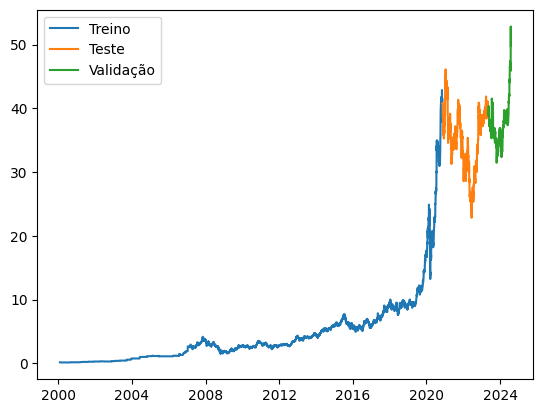

In [9]:
plt.plot(dates_train,y_train, label='Treino')
plt.plot(dates_test,y_test, label='Teste')
plt.plot(dates_validation,y_validation, label='Validação')
plt.legend()

## Treinamento da LSTM

## Resultado com dados nunca vistos pelo modelo

In [10]:
model_lstm = train_model_lstm(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_lstm)

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 26.0577 - mean_absolute_error: 2.1505 - val_loss: 3.3000 - val_mean_absolute_error: 1.4001
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1971 - mean_absolute_error: 0.1969 - val_loss: 2.5785 - val_mean_absolute_error: 1.2475
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1846 - mean_absolute_error: 0.1958 - val_loss: 1.7098 - val_mean_absolute_error: 0.9870
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1204 - mean_absolute_error: 0.1768 - val_loss: 1.7148 - val_mean_absolute_error: 1.0044
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1644 - mean_absolute_error: 0.1977 - val_loss: 8.8378 - val_mean_absolute_error: 2.6894
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1741 - mean_absolute_error: 0.1882 - val_loss: 2.4014 - val_mean_absolute_error: 1.2753
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1357 - mean_absolute_error: 0.

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


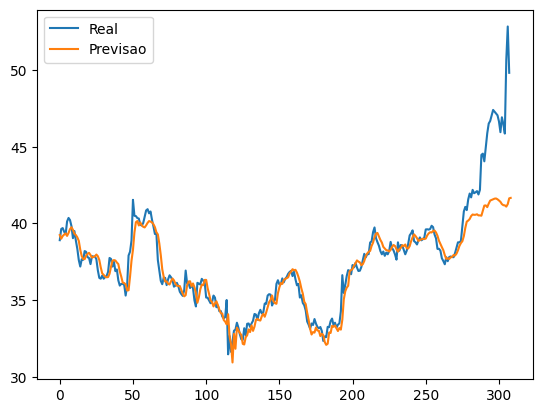

In [11]:
y_pred = model_lstm.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred), label="Previsao")
plt.legend()

In [12]:
model_feedforward = train_model_feedforward(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_feedforward)

Epoch 1/100


/home/nikolas/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9185 - mean_absolute_error: 0.8407 - val_loss: 0.9607 - val_mean_absolute_error: 0.7412
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0598 - mean_absolute_error: 0.1034 - val_loss: 0.9230 - val_mean_absolute_error: 0.7502
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0606 - mean_absolute_error: 0.1020 - val_loss: 1.5741 - val_mean_absolute_error: 1.0552
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0891 - mean_absolute_error: 0.1294 - val_loss: 1.1141 - val_mean_absolute_error: 0.8289
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0579 - mean_absolute_error: 0.1041 - val_loss: 0.8306 - val_mean_absolute_error: 0.7101
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0538 - mean_absolute_error: 0.0901 - val_loss: 0.7945 - val_mean_absolute_error: 0.6753
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607 - mean_absolute_error: 0.1042 - val_lo

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


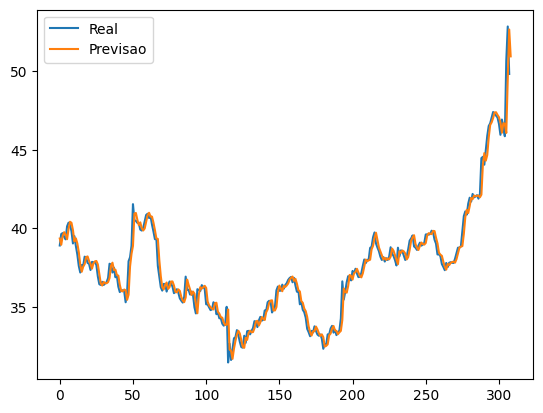

In [13]:
y_pred = model_feedforward.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred), label="Previsao")
plt.legend()

In [14]:
model_rnn = train_model_rnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_rnn)

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 26.6834 - mean_absolute_error: 2.0861 - val_loss: 617.4269 - val_mean_absolute_error: 24.3983
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11.4521 - mean_absolute_error: 0.7452 - val_loss: 446.0341 - val_mean_absolute_error: 20.5884
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1301 - mean_absolute_error: 0.6365 - val_loss: 323.7663 - val_mean_absolute_error: 17.3672
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4578 - mean_absolute_error: 0.4755 - val_loss: 240.5444 - val_mean_absolute_error: 14.7786
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.4800 - mean_absolute_error: 0.4782 - val_loss: 179.6605 - val_mean_absolute_error: 12.5516
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7255 - mean_absolute_error: 0.3874 - val_loss: 133.3025 - val_mean_absolute_error: 10.5568
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8613 - mean

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


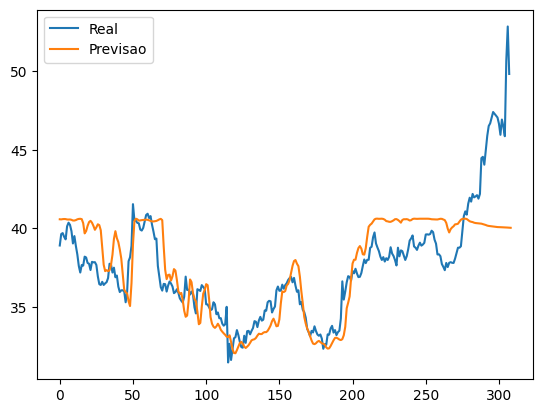

In [15]:
y_pred = model_rnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred), label="Previsao")
plt.legend()